In [7]:
function parse_line(line)
    n = parse(Int, line[28:30])
    month = parse(Int, line[22:23])
    day = parse(Int, line[24:27])
    year = parse(Int, line[18:21])
    station_id = parse(Int, line[4:9])
    offset = 30 + 12 * (n-1)
    hour = parse(Int,line[offset + 1:offset + 2])
    
    cum_val = parse(Int, line[offset + 5: offset + 10]) #* 0.01
    flag = line[offset+11]
    if hour != 25
        @show hour
        @show flag, cum_val
    end
    missing = 0
    for i=1:n-1
        offset = 30 + 12 * (i-1)
        fl = line[offset + 11]
        if fl == '{' || fl == '[' || fl == 'a' || fl == ','
            missing = 1
        elseif fl == '}' || fl == ']' || fl == 'A'
            missing = 0
        else
            missing = 0
        end
    end

    station_id, year, month, day, cum_val, flag, missing
end
using DataFrames

function parse_file(filename)
    lines = open(filename) do f 
        readlines(f)
    end
    n = 30 * length(lines) 
    i = 1
    df = DataFrame()
    df[:station_id] = fill(-1, n)
    df[:year] = fill(-1, n)
    df[:month] = fill(-1, n)
    df[:day] = fill(-1, n)
    df[:precipitation] = fill(-1, n)
    df[:flag] = fill('m', n)
    mis = 1
    dday = Dates.Day(1)
    oldid = -1
    olddate = Date(1800, 1, 1)
    for line in lines
        id, y, m, d, v, f, mis2 = parse_line(line)
        curdate = Date(y, m, d)
        olddate += dday
        while mis == 0 && oldid == id && curdate > olddate
            df[i, 1] = oldid
            df[i, 2] = Dates.year(olddate)
            df[i, 3] = Dates.month(olddate)
            df[i, 4] = Dates.day(olddate)
            df[i, 5] = 0
            df[i, 6] = 'f'
            i += 1
            olddate += dday
        end
        df[i, 1] = id
        df[i, 2] = y
        df[i, 3] = m
        df[i, 4] = d
        df[i, 5] = v
        df[i, 6] = f
        olddate = Date(y, m, d)
        oldid = id
        mis = mis2
        i += 1
    end
    df
end


parse_file (generic function with 1 method)

In [8]:
dirs = filter(isdir, AbstractString[@sprintf("%02i", i) for i=1:51])
alldf = DataFrame()
files = AbstractString[]
for i=1:51
    isdir(@sprintf("%02i", i)) || continue
    fn = @sprintf("%02i/data.dat", i)
    if !isfile(fn)
        warn("File $fn does not exist, continue.")
        continue
    end
    push!(files, fn)
end
for i=2011:2014
    for f in readdir("by_month$i")
        fn = joinpath("by_month$i",f)
        if isfile(fn)
            push!(files, fn)
        end
    end
end
files;


In [9]:
using ProgressMeter
new = true
@showprogress for fn in files
    df = parse_file(fn)
    m = size(df, 1)
    df = df[(df[:flag] .== ' ') | (df[:flag] .== 'f'),:]
    n = size(df, 1)
    filled = sum(df[:flag] .== 'f')
    #println("$n out of $m entries okay, $filled were filled in.")
    if new
        alldf = df
        new = false
    else
        append!(alldf, df)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


In [11]:
function add_daycount!(df, start=Date(1940, 1, 1))
    y = df[:year]
    m = df[:month]
    d = df[:day]
    df[:time] = Int64[Int(Date(y[i], m[i], d[i]) - start) for i=1:length(y)]
end
function filter_stations(stations)
    f = (stations[:latitude] .<= -50) & (stations[:latitude] .>= -130)
    f &= (stations[:longitude] .>= 20) & (stations[:longitude] .<= 52)
    stations[f, :]
end
stations = readtable("stations.csv")
stations = filter_stations(stations)
@time fulldf = join(alldf, stations, on=:station_id);
@time add_daycount!(fulldf);
delete!(fulldf, :name)
delete!(fulldf, :flag)
pr = fulldf[:precipitation]
delete!(fulldf, :precipitation)
fulldf[:precipitation] = pr
fulldf

 28.357411 seconds (299.09 M allocations: 10.853 GB, 1.95% gc time)
 29.151256 seconds (781.46 M allocations: 14.788 GB, 8.59% gc time)


,station_id,year,month,day,latitude,longitude,time,precipitation
1,10008,1999,1,1,-85.24819955743311,31.57020016093341,21550,0
2,10008,1999,1,2,-85.24819955743311,31.57020016093341,21551,0
3,10008,1999,1,3,-85.24819955743311,31.57020016093341,21552,90
4,10008,1999,1,4,-85.24819955743311,31.57020016093341,21553,0
5,10008,1999,1,5,-85.24819955743311,31.57020016093341,21554,0
6,10008,1999,1,6,-85.24819955743311,31.57020016093341,21555,0
7,10008,1999,1,7,-85.24819955743311,31.57020016093341,21556,0
8,10008,1999,1,8,-85.24819955743311,31.57020016093341,21557,0
9,10008,1999,1,9,-85.24819955743311,31.57020016093341,21558,80
10,10008,1999,1,10,-85.24819955743311,31.57020016093341,21559,0


In [20]:
fulldf = readtable("processed-data.csv")

,station_id,year,month,day,latitude,longitude,time,precipitation
1,10008,1999,1,1,-85.24819955743311,31.57020016093341,21550,0
2,10008,1999,1,2,-85.24819955743311,31.57020016093341,21551,0
3,10008,1999,1,3,-85.24819955743311,31.57020016093341,21552,90
4,10008,1999,1,4,-85.24819955743311,31.57020016093341,21553,0
5,10008,1999,1,5,-85.24819955743311,31.57020016093341,21554,0
6,10008,1999,1,6,-85.24819955743311,31.57020016093341,21555,0
7,10008,1999,1,7,-85.24819955743311,31.57020016093341,21556,0
8,10008,1999,1,8,-85.24819955743311,31.57020016093341,21557,0
9,10008,1999,1,9,-85.24819955743311,31.57020016093341,21558,80
10,10008,1999,1,10,-85.24819955743311,31.57020016093341,21559,0


In [22]:
writetable("processed-data-2010-2011.csv", fulldf[(fulldf[:year] .>= 2010) & (fulldf[:year] .<= 2011),:])

In [17]:
using DataFrames
using PyPlot
plt[:style][:use]("ggplot")
df = readtable("processed-data-2010.csv")
writetable("processed-data-2010-jan.csv", df[(df[:month] .== 1), :])

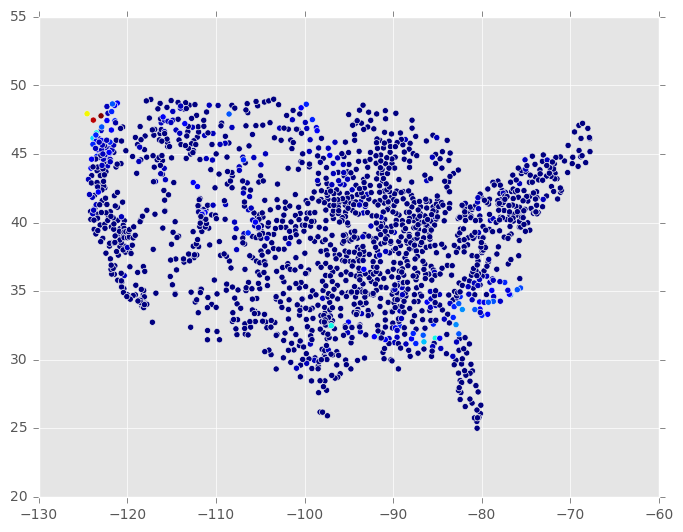

PyObject <matplotlib.collections.PathCollection object at 0x7fd670905890>

In [18]:
myday= df[(df[:year] .== 2010) & (df[:month] .== 2) & (df[:day] .== 13), :]
scatter(myday[:latitude], myday[:longitude], c = myday[:precipitation])

In [ ]:
# Extracts all files
dirs = filter(isdir, AbstractString[@sprintf("%02i", i) for i=1:51])
for dir in dirs
    outpath = joinpath(dir, "data")
    run(`mkdir -p $outpath`)
    for file in readdir(dir)
        if length(file) > 4 && file[end-4:end] == "tar.Z"
            fn = joinpath(dir, file)
            run(`tar -xzf $fn -C $outpath`)
        end
    end
    run(`bash -c "cat $outpath/* > $dir/data.dat"`)
end

In [2]:
stations = readtable("stations.csv")

,station_id,latitude,longitude,name
1,13200,-86.75,34.01666968416818,"GARDEN CITY, AL US"
2,13655,-86.79099979883323,34.06780024140012,"HANCEVILLE, AL US"
3,13645,-87.99129953731644,34.09660028163347,"HAMILTON 3 S, AL US"
4,10957,-86.16330014081673,34.20079963789982,"BOAZ, AL US"
5,10063,-87.18140012070006,34.2552997384832,"ADDISON, AL US"
6,13620,-87.63520016093341,34.23140012070006,"HALEYVILLE, AL US"
7,13043,-85.72359987929994,34.440600482800235,"FORT PAYNE, AL US"
8,14064,-86.78611044055522,34.64388955944477,"HUNTSVILLE INTERNATIONAL AIRPORT JONES FIELD, AL US"
9,11099,-85.80079963789981,34.978599879299935,"BRIDGEPORT 5 NW, AL US"
10,10748,-87.64909977871656,33.69719975859988,"BERRY 3 NW, AL US"


In [ ]:
sum(alldf[:station_id] .== 13655)

# Station Locations

In [ ]:
using LightXML
xdoc = parse_file("precip_hly.shp.kml");
doc = find_element(root(xdoc), "Document");
ces = get_elements_by_tagname(doc, "Placemark");
length(ces)

In [ ]:
using DataFrames
reg = r"COOP:([0-9]{6})"
df = DataFrame()
df[:station_id] = 1:length(ces)
df[:latitude] = fill(NaN, length(ces))
df[:longitude] = fill(NaN, length(ces))
df[:name] = fill("", length(ces))

for (i, c) in enumerate(ces)
    
    pt = find_element(c, "Point");
    coords = Float64[parse(Float64, d) for d in split(content(find_element(pt, "coordinates")), ",")];
    desc = content(find_element(c, "description"))
    ids = match(reg,desc)[1]
    id = parse(Int,ids)
    df[i, [:station_id]] = id
    df[i, [:longitude]] = coords[2]
    df[i, [:latitude]] = coords[1]
    df[i, [:name]] = content(find_element(c, "name"))
    
end

In [ ]:
df
writetable("stations.csv", df)

filter_stations (generic function with 1 method)

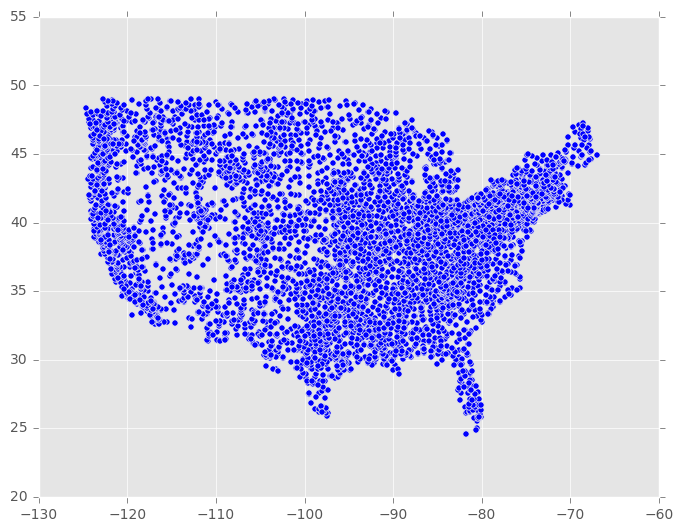

PyObject <matplotlib.collections.PathCollection object at 0x7f35a2d04e90>

In [19]:
using PyPlot
plt[:style][:use]("ggplot")
st = filter_stations(stations)
scatter(st[:latitude], st[:longitude])

In [ ]:
fulldf